In [1]:
%%html
<link rel='stylesheet' type='text/css' href='custom.css'/>

In [2]:
!rm data/converted-seqs.fasta data/converted-seqs.qual data/not-yasf.fna

rm: cannot remove ‘data/converted-seqs.fasta’: No such file or directory
rm: cannot remove ‘data/converted-seqs.qual’: No such file or directory
rm: cannot remove ‘data/not-yasf.fna’: No such file or directory


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('Known taxonomy')
    plt.xlabel('Predicted taxonomy')
    plt.tight_layout()
    plt.show()

![](assets/logo.svg)

# A Bioinformatics Library for Data Scientists, Students, and Developers

Jai Rideout and Evan Bolyen

*[Caporaso Lab](http://caporasolab.us), Northern Arizona University*

## What is scikit-bio?

A Python bioinformatics library for:

- data scientists

- students

- developers

> "The first step in developing a new genetic analysis algorithm is to decide how to make the input data file format different from all pre-existing analysis data file formats." - [Law's First Law](http://www.bioinformatics.roslin.ed.ac.uk/lawslaws/)















<span style='line-height:2em; word-spacing:2em'>Axt BAM SAM BED bedGraph bigBed bigGenePred table bigWig Chain GenePred table GFF GTF HAL MAF Microarray Net Personal Genome SNP format PSL VCF WIG  abi ace clustal embl fasta fastq genbank ig imgt nexus phred phylip pir seqxml sff stockholm swiss tab qual uniprot-xml emboss PhyolXML NexML newick CDAO MDL bcf caf gcproj scf SBML lsmat ordination qseq BIOM ASN.1 .2bit .nib ENCODE ... </span>

<span style='line-height:2em; word-spacing:2em'>Axt BAM SAM BED bedGraph bigBed bigGenePred table bigWig Chain GenePred table GFF GTF HAL MAF Microarray Net Personal Genome SNP format PSL VCF WIG  abi ace <span class='supio'>clustal</span> embl <span class='supio'>fasta</span> <span class='supio'>fastq</span> genbank ig imgt nexus phred <span class='supio'>phylip</span> pir seqxml sff stockholm swiss tab qual uniprot-xml emboss PhyolXML NexML <span class='supio'>newick</span> CDAO MDL bcf caf gcproj scf SBML <span class='supio'>lsmat</span> <span class='supio'>ordination</span> <span class='supio'>qseq</span> BIOM ASN.1 .2bit .nib ENCODE ... </span>

## I/O in bioinformatics is hard


- format redundancy (many-to-many)

- format ambiguity

- heterogeneous sources

## How can we solve this?


# An I/O Registry!

## Format redundancy (many-to-many)


In [4]:
from skbio import DNA

seq1 = DNA.read('data/seqs.fasta', qual='data/seqs.qual')
seq2 = DNA.read('data/seqs.fastq', variant='illumina1.8')
seq1

DNA
---------------------------------------------------------------------
Metadata:
    'description': ''
    'id': 'M10_68:1:1:19607:29475#0/1'
Positional metadata:
    'quality': <dtype: uint8>
Stats:
    length: 152
    has gaps: False
    has degenerates: False
    has non-degenerates: True
    GC-content: 45.39%
---------------------------------------------------------------------
0   GACATAAGGG TGGTTAGTAT ACCGGCAAGG ACGGGGTTAC TAGTGACGTC CTTCCCCGTA
60  TGCCGGGCAA TAATGTTTAT GTTGGTTTCA TGGTTTGGTC TAACTTTACC GCTACTAAAT
120 GCTGCGGATT GGTTTCGCTG AATCAGATTA TT

In [5]:
seq1 == seq2

True

## Format ambiguity

In [6]:
import skbio.io

skbio.io.sniff('data/mystery_file.gz')

('lsmat', {'delimiter': ','})

## Heterogeneous sources

#### Read a gzip file from a URL:

In [7]:
from skbio import TreeNode

tree1 = skbio.io.read('http://localhost:8888/files/data/newick.gz', 
                      into=TreeNode)
print(tree1.ascii_art())

                    /-a
                   |
          /--------|--b
         |         |
---------|          \-c
         |
          \-d


#### Read a bz2 file from a file path:

In [8]:
import io 

with io.open('data/newick.bz2', mode='rb') as open_filehandle:
    tree2 = skbio.io.read(open_filehandle, into=TreeNode)

print(tree2.ascii_art())

                    /-a
                   |
          /--------|--b
         |         |
---------|          \-c
         |
          \-d


#### Read a list of lines:

In [9]:
tree3 = skbio.io.read(['((a, b, c), d:15):0;'], into=TreeNode)
print(tree3.ascii_art())

                    /-a
                   |
          /--------|--b
         |         |
---------|          \-c
         |
          \-d


## Let's make a format!

#YASF (Yet Another Sequence Format)

In [10]:
!cat data/yasf-seq.yml

#YASF
ID: presentation-id-1
Location: Austin, TX
Description: SciPy 2015 is awesome!
Sequence: >
    ACGTGCTAGCTCGATCGCTAGCCCGAGAGCGCAGCGCGCTAGCTCGATCGCGCTAGAGAGAGATCGCGCTAGCGWA

In [11]:
import yaml

yasf = skbio.io.create_format('yasf')

@yasf.sniffer()
def yasf_sniffer(fh):
    return fh.readline().rstrip() == "#YASF", {}

@yasf.reader(DNA)
def yasf_to_dna(fh):
    seq = yaml.load(fh.read())
    return DNA(seq['Sequence'], metadata={
        'id': seq['ID'],
        'location': seq['Location'],
        'description': seq['Description']
    })

In [12]:
seq = DNA.read("data/yasf-seq.yml")
seq

DNA
--------------------------------------------------------------------
Metadata:
    'description': 'SciPy 2015 is awesome!'
    'id': 'presentation-id-1'
    'location': 'Austin, TX'
Stats:
    length: 76
    has gaps: False
    has degenerates: True
    has non-degenerates: True
    GC-content: 63.16%
--------------------------------------------------------------------
0  ACGTGCTAGC TCGATCGCTA GCCCGAGAGC GCAGCGCGCT AGCTCGATCG CGCTAGAGAG
60 AGATCGCGCT AGCGWA

## Convert YASF to FASTA

In [13]:
seq.write("data/not-yasf.fna", format='fasta')
!cat data/not-yasf.fna

>presentation-id-1 SciPy 2015 is awesome!
ACGTGCTAGCTCGATCGCTAGCCCGAGAGCGCAGCGCGCTAGCTCGATCGCGCTAGAGAGAGATCGCGCTAGCGWA


## We are in beta - should you even use our software?

#YES!

## API Lifecycle
![](assets/stability-state-diagram.svg)


In [14]:
from skbio.util._decorator import stable

@stable(as_of='0.4.0')
def add(a, b):
    """add two numbers.
    
    Parameters
    ----------
    a, b : int
        Numbers to add.
        
    Returns
    -------
    int
        Sum of `a` and `b`.
    
    """
    return a + b

In [15]:
help(add)

Help on function add in module __main__:

add(a, b)
    add two numbers.
    
    State: Stable as of 0.4.0.
    
    Parameters
    ----------
    a, b : int
        Numbers to add.
        
    Returns
    -------
    int
        Sum of `a` and `b`.



### What is stable:

- `skbio.io` 
- `skbio.sequence`

&nbsp;
&nbsp;
###What is next:

- `skbio.alignment`
- `skbio.tree`
- `skbio.diversity`
- `skbio.stats`
- &lt;`your awesome subpackage!`&gt;

## Sequence API: putting the *scikit* in scikit-bio

In [16]:
seq = DNA("AacgtGTggA", lowercase='exon')
seq

DNA
-----------------------------
Positional metadata:
    'exon': <dtype: bool>
Stats:
    length: 10
    has gaps: False
    has degenerates: False
    has non-degenerates: True
    GC-content: 50.00%
-----------------------------
0 AACGTGTGGA

## Made with numpy

In [17]:
seq.values

array([b'A', b'A', b'C', b'G', b'T', b'G', b'T', b'G', b'G', b'A'], 
      dtype='|S1')

## And a pinch of pandas

In [18]:
seq.positional_metadata

,exon
0,False
1,True
2,True
3,True
4,True
5,False
6,False
7,True
8,True
9,False


## Slicing with positional metadata:

In [19]:
seq[seq.positional_metadata['exon']]

DNA
-----------------------------
Positional metadata:
    'exon': <dtype: bool>
Stats:
    length: 6
    has gaps: False
    has degenerates: False
    has non-degenerates: True
    GC-content: 66.67%
-----------------------------
0 ACGTGG

## Application: building a taxonomy classifier

In [20]:
aligned_seqs_fp = 'data/gg_13_8_otus/rep_set_aligned/82_otus.fasta'
taxonomy_fp = 'data/gg_13_8_otus/taxonomy/82_otu_taxonomy.txt'

In [21]:
from skbio import DNA

fwd_primer = DNA("GTGCCAGCMGCCGCGGTAA",
                 metadata={'label':'fwd-primer'})
rev_primer = DNA("GGACTACHVGGGTWTCTAAT",
                 metadata={'label':'rev-primer'}).reverse_complement()

In [22]:
def seq_to_regex(seq):
    result = []
    for base in str(seq):
        if base in DNA.degenerate_chars:
            result.append('[{0}]'.format(
                ''.join(DNA.degenerate_map[base])))
        else:
            result.append(base)

    return ''.join(result)

regex = '({0}.*{1})'.format(seq_to_regex(fwd_primer),
                            seq_to_regex(rev_primer))

In [23]:
import numpy as np
import skbio

starts = []
stops = []
for seq in skbio.io.read(aligned_seqs_fp, format='fasta', 
                         constructor=DNA):
    for match in seq.find_with_regex(regex, ignore=seq.gaps()):
        starts.append(match.start)
        stops.append(match.stop)
        
locus = slice(int(np.median(starts)), int(np.median(stops)))
locus

slice(2227, 4090, None)

In [24]:
kmer_counts = []
seq_ids = []
for seq in skbio.io.read(aligned_seqs_fp, format='fasta',
                         constructor=DNA):
    seq_ids.append(seq.metadata['id'])
    sliced_seq = seq[locus].degap()
    kmer_counts.append(sliced_seq.kmer_frequencies(8))

In [25]:
from sklearn.feature_extraction import DictVectorizer
X = DictVectorizer().fit_transform(kmer_counts)

In [26]:
taxonomy_level = 3 # class
id_to_taxon = {}
with open(taxonomy_fp) as f:
    for line in f:
       id_, taxon = line.strip().split('\t')
       id_to_taxon[id_] = '; '.join(taxon.split('; ')[:taxonomy_level])

y = [id_to_taxon[seq_id] for seq_id in seq_ids]

In [27]:
from sklearn.feature_selection import SelectPercentile

X = SelectPercentile().fit_transform(X, y)

In [28]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)

In [29]:
from sklearn.svm import SVC

y_pred = SVC(C=10, kernel='linear', degree=3,
             gamma=0.001).fit(X_train, y_train).predict(X_test)

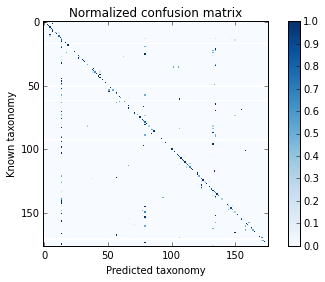

F-score: 0.654


In [30]:
from sklearn.metrics import confusion_matrix, f1_score

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

print("F-score: %1.3f" % f1_score(y_test, y_pred, average='micro'))

# Acknowledgements


[scikit-bio development team](https://github.com/biocore/scikit-bio/graphs/contributors)

## Funding


* Alfred P Sloan Foundation
* National Science Foundation
* National Institutes of Health
* Arizona Board of Regents Technology and Research Investment Fund

**The Caporaso Lab is hiring postdocs and developers, find us if you want to get paid to work on scikit-bio!**

**We're having a sprint on Saturday and Sunday!** 